### Question 1: [IPO] Withdrawn IPOs by Company Type

What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?

From the withdrawn IPO list (https://stockanalysis.com/ipos/withdrawn), collect and process the data to find out which company type saw the most withdrawn IPO value.

* Step 1: Use pandas.read_html() with the URL above to load the IPO withdrawal table into a DataFrame. It is a similar process to Code Snippet 1 discussed at the livestream. You should get 99 entries

In [ ]:
import pandas as pd
import requests
from io import StringIO

url = 'https://stockanalysis.com/ipos/withdrawn/'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
                  "AppleWebKit/537.36 (KHTML, like Gecko)"
                  "Chrome/91.0.4472.124 Safari/537.36"
}
response = requests.get(url, headers=headers)
response = StringIO(response.text)
df = pd.read_html(response)[0]
df

,Symbol,Company Name,Price Range,Shares Offered


from bs4 import BeautifulSoup,
*soup = BeautifulSoup(response.content, 'html.parser'),
*tables = pd.read_html(str(soup))
*df = tables[0]

Step 2:
* Create a new column called Company Class, categorizing company names based on patterns like:
- “Acquisition Corp” or “Acquisition Corporation” → Acq.Corp
- “Inc” or “Incorporated” → Inc
- “Group” → Group
- “Ltd” or “Limited” → Limited
- “Holdings” → Holdings
- Others → Other

Order: Please follow the listed order of classes and assign the first matched value (e.g., for 'shenni holdings limited', you assign the 'Limited' class).

Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

In [ ]:
def classify_company(company_name):
    """
    Classify company names based on specific patterns.
    Returns the first matching classification in order of priority.
    """
    if pd.isna(company_name):
        return 'Other'

    # Convert to lowercase and remove punctuation for robust matching
    import re
    name_lower = company_name.lower()
    # Remove punctuation and extra spaces
    name_clean = re.sub(r'[^\w\s]', ' ', name_lower)
    words = name_clean.split()

    # Also check the original string for pattern matching
    name_lower_original = name_lower.strip()

    # Check patterns in the specified order
    # 1. Acquisition Corp patterns
    acquisition_terms = ['acquisition']
    corp_terms = ['corp', 'corporation']
    if any(term in words for term in acquisition_terms) and \
       any(term in words for term in corp_terms):
        return 'Acq.Corp'

    # 2. Inc patterns (check for inc, inc., incorporated)
    inc_terms = ['inc', 'incorporated']
    if any(term in words for term in inc_terms) or \
       name_lower_original.endswith('inc.') or \
       name_lower_original.endswith('inc'):
        return 'Inc'

    # 3. Group patterns
    if 'group' in words:
        return 'Group'

    # 4. Limited patterns (check for ltd, ltd., limited)
    limited_terms = ['ltd', 'limited']
    if any(term in words for term in limited_terms) or \
       name_lower_original.endswith('ltd.') or \
       name_lower_original.endswith('ltd'):
        return 'Limited'

    # 5. Holdings patterns
    if 'holdings' in words:
        return 'Holdings'

    # 6. Default to Other
    return 'Other'

# Apply the function to create the new column
df['Company Class'] = df['Company Name'].apply(classify_company)


In [ ]:
#df.sample(10)

Step 3:
Define a new field Avg. price by parsing the Price Range field (create a function and apply it to the Price Range column). Examples:
* '$8.00-$10.00' → 9.0
* '$5.00' → 5.0
* '-' → None

In [ ]:
def parse_avg_price(price_range):
    """
    Parses the Price Range string and returns the average price as a float.
    Handles:
    - '$8.00 - $10.00' → 9.0
    - '$5.00' → 5.0
    - '-' → None
    - '-' or invalid → None
    """
    import re
    if pd.isna(price_range) or price_range.strip() == '-':
        return None

    # Extract all numbers from the string
    prices = re.findall(r'\$?(\d+(?:\.\d+)?)', price_range)

    if not prices:
        return None

    # Convert to float
    prices = [float(p) for p in prices]

    # Return the average
    return sum(prices) / len(prices)

# Apply the function to create the new column
df['Avg. price'] = df['Price Range'].apply(parse_avg_price)

Step 4:
Convert Shares Offered to numeric, clean missing or invalid values.

In [ ]:
df['Shares Offered'] = pd.to_numeric(df['Shares Offered'], errors='coerce')
df['Shares Offered'].dtype

dtype('float64')

In [ ]:
# drop all NaNs
df = df.dropna()

Step 5: Create a new column:
```Withdrawn Value = Shares Offered * Avg Price (71 non-null values)```

In [ ]:
df.loc[:, 'Withdrawn Value'] = df['Shares Offered'] * df['Avg. price']
df

<ipython-input-8-3584859480>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Withdrawn Value'] = df['Shares Offered'] * df['Avg. price']


,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price,Withdrawn Value
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Inc,3.5,7000000.0
5,HPOT,The Great Restaurant Development Holdings Limited,$4.00 - $6.00,1400000.0,Limited,5.0,7000000.0
6,CABR,"Caring Brands, Inc.",$4.00,750000.0,Inc,4.0,3000000.0
7,SQVI,"Sequoia Vaccines, Inc.",$8.00 - $10.00,2775000.0,Inc,9.0,24975000.0
8,SNI,Shenni Holdings Limited,$4.00 - $6.00,3000000.0,Limited,5.0,15000000.0
...,...,...,...,...,...,...,...
92,DPAC,Deep Space Acquisition Corp. I,$10.00,21000000.0,Acq.Corp,10.0,210000000.0
93,GIF,"GigCapital6, Inc.",$10.00,20000000.0,Inc,10.0,200000000.0
94,HYIV,Haymaker Acquisition Corp. IV,$10.00,26100000.0,Acq.Corp,10.0,261000000.0
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231.0,Inc,19.5,600000004.5


Step 6: Group by ```Company Class``` and calculate total withdrawn value.

In [ ]:
company_class_withdrawal = df.groupby('Company Class')['Withdrawn Value'].sum()
company_class_withdrawal

,Withdrawn Value
Company Class,
Acq.Corp,4.021000e+09
Group,3.378750e+07
Holdings,7.500000e+07
Inc,2.257164e+09
Limited,5.497346e+08
Other,7.679200e+08


Step 7: Which class had the highest total value of withdrawals

In [ ]:
company_class_withdrawal.sort_values(ascending=False)

,Withdrawn Value
Company Class,
Acq.Corp,4.021000e+09
Inc,2.257164e+09
Other,7.679200e+08
Limited,5.497346e+08
Holdings,7.500000e+07
Group,3.378750e+07


### Question 2: [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)
**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale yfinance OHLCV data download and perform basic financial calculations on IPO stocks.

Step 1: Using the same approach as in Question 1, download the IPOs in 2024 from:
https://stockanalysis.com/ipos/2024/
Filter to keep only those IPOs before 1 June 2024 (first 5 months of 2024).
➤ You should have 75 tickers.

In [5]:
import pandas as pd
import requests
from io import StringIO

url = 'https://stockanalysis.com/ipos/2024/'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
                  "AppleWebKit/537.36 (KHTML, like Gecko)"
                  "Chrome/91.0.4472.124 Safari/537.36"
}
response = requests.get(url, headers=headers)
response = StringIO(response.text)
df_2024 = pd.read_html(response)[0]
df_2024.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 31, 2024",ONEG,OneConstruction Group Limited,$4.00,$4.82,20.55%
1,"Dec 27, 2024",PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$23.95,498.75%
2,"Dec 23, 2024",HIT,"Health In Tech, Inc.",$4.00,$0.60,-85.00%
3,"Dec 23, 2024",TDAC,Translational Development Acquisition Corp.,$10.00,$10.26,2.60%
4,"Dec 20, 2024",RANG,Range Capital Acquisition Corp.,$10.00,$10.20,2.00%


In [6]:
# Ensure IPO Date is in datetime format
df_2024['IPO Date'] = pd.to_datetime(df_2024['IPO Date'], errors='coerce')

In [7]:
# set IPO Date as index
df_2024 = df_2024.set_index('IPO Date')

In [8]:
# check for duplicates
df_2024.duplicated().sum()

np.int64(0)

In [9]:
# Filter to keep only IPOs before June 1, 2024
df_filter = df_2024[df_2024.index < '2024-06-01']

In [10]:
# check IPO Price with nothing
(df_filter['IPO Price'] == '-').value_counts()

,count
IPO Price,
False,75
True,2


In [11]:
# Drop rows with missing IPO Price ("-")
df_filter = df_filter[df_filter['IPO Price'] != '-']
len(df_filter)

75

Step 2: Use Code Snippet 7 to download daily stock data for those tickers (via yfinance).
Make sure you understand how growth_1d ... growth_365d, and volatility columns are defined.
Define a new column growth_252d representing growth after 252 trading days (~1 year), in addition to any other growth periods you already track.

In [12]:
# check for dates
df_filter.index

DatetimeIndex(['2024-05-23', '2024-05-17', '2024-05-17', '2024-05-15',
               '2024-05-15', '2024-05-14', '2024-05-10', '2024-05-09',
               '2024-05-09', '2024-05-09', '2024-05-08', '2024-05-02',
               '2024-05-01', '2024-04-26', '2024-04-25', '2024-04-25',
               '2024-04-25', '2024-04-23', '2024-04-22', '2024-04-22',
               '2024-04-19', '2024-04-18', '2024-04-18', '2024-04-18',
               '2024-04-18', '2024-04-16', '2024-04-12', '2024-04-11',
               '2024-04-10', '2024-04-05', '2024-04-02', '2024-04-02',
               '2024-03-28', '2024-03-28', '2024-03-28', '2024-03-26',
               '2024-03-22', '2024-03-21', '2024-03-21', '2024-03-21',
               '2024-03-20', '2024-03-20', '2024-03-06', '2024-03-05',
               '2024-02-27', '2024-02-22', '2024-02-21', '2024-02-16',
               '2024-02-14', '2024-02-09', '2024-02-09', '2024-02-09',
               '2024-02-09', '2024-02-08', '2024-02-08', '2024-02-07',
      

In [13]:
# Number of Unique IPO STOCKS
df_filter['Symbol'].nunique()

75

* Get the IPO STOCKS

In [14]:
IPO_TICKERS = df_filter['Symbol'].to_list()
len(IPO_TICKERS)

75

In [15]:
import time
import numpy as np
import yfinance as yf

ipo_stocks_df = pd.DataFrame({'A' : []})

for i, ticker in enumerate(IPO_TICKERS):
  print(f"{i}: {ticker}")

  # Work with IPO stock prices
  ticker_obj = yf.Ticker(ticker)

  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns for 1-day, 1-week, 1-month, 1-year
  for j in [1,7,30, 252]:
    historyPrices['growth_'+str(j)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(j)

  # 252_days(1-year) Future Growth
  #historyPrices['growth_future_252d'] = historyPrices['Close'].shift(-252) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] = historyPrices['growth_1d'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  #historyPrices['is_positive_growth_252d_future'] = np.where(historyPrices['growth_future_252d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)

  if ipo_stocks_df.empty:
    ipo_stocks_df = historyPrices
  else:
    ipo_stocks_df = pd.concat([ipo_stocks_df, historyPrices], ignore_index=True)

0: BOW
1: HDL
2: RFAI
3: JDZG
4: RAY
5: BTOC
6: ZK
7: GPAT
8: PAL
9: SVCO
10: NNE
11: CCIX
12: VIK
13: ZONE
14: LOAR
15: MRX
16: RBRK
17: NCI
18: MFI
19: YYGH
20: TRSG
21: CDTG
22: CTRI
23: IBTA
24: MTEN
25: TWG
26: ULS
27: PACS
28: MNDR
29: CTNM
30: MAMO
31: ZBAO
32: BOLD
33: MMA
34: UBXG
35: IBAC
36: AUNA
37: BKHA
38: LOBO
39: RDDT
40: ALAB
41: INTJ
42: RYDE
43: LGCL
44: SMXT
45: VHAI
46: DYCQ
47: CHRO
48: UMAC
49: HLXB
50: MGX
51: TBBB
52: TELO
53: KYTX
54: PMNT
55: AHR
56: LEGT
57: ANRO
58: GUTS
59: AS
60: FBLG
61: AVBP
62: BTSG
63: HAO
64: CGON
65: YIBO
66: JL
67: SUGP
68: JVSA
69: KSPI
70: CCTG
71: PSBD
72: SYNX
73: SDHC
74: ROMA


In [16]:
ipo_stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Date,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility
0,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,2024-05-23,NaN,NaN,NaN,NaN,NaN,NaN,0,0.089496,NaN
1,24.260000,26.150000,23.980000,25.700001,990500,0.0,0.0,BOW,2024,5,...,2024-05-24,1.079832,NaN,NaN,NaN,NaN,NaN,0,0.084436,NaN
2,25.850000,26.879999,25.075001,26.480000,555100,0.0,0.0,BOW,2024,5,...,2024-05-28,1.030350,NaN,NaN,NaN,NaN,NaN,0,0.068165,NaN
3,26.440001,26.490000,25.500999,26.290001,302700,0.0,0.0,BOW,2024,5,...,2024-05-29,0.992825,NaN,NaN,NaN,NaN,NaN,0,0.037619,NaN
4,27.209999,27.209999,25.500000,26.139999,200900,0.0,0.0,BOW,2024,5,...,2024-05-30,0.994294,NaN,NaN,NaN,NaN,NaN,0,0.065417,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23241,3.021000,3.050000,2.850000,2.880000,36300,0.0,0.0,ROMA,2025,6,...,2025-06-12,0.960000,0.844575,2.360656,5.938144,3.2390,2.78955,1,0.069444,1.334095
23242,2.870000,2.890000,2.560000,2.660000,123100,0.0,0.0,ROMA,2025,6,...,2025-06-13,0.923611,0.707447,1.934546,4.666667,3.1970,2.82155,1,0.124060,1.339043
23243,2.840000,3.000000,2.640000,2.875000,63100,0.0,0.0,ROMA,2025,6,...,2025-06-16,1.080827,0.805322,1.955782,5.424529,3.1485,2.86180,1,0.125217,1.342776
23244,2.850000,2.935000,2.790000,2.795000,10200,0.0,0.0,ROMA,2025,6,...,2025-06-17,0.972174,0.755405,1.814935,5.008960,3.0870,2.89955,1,0.051878,1.350040


In [17]:
# check for missing values
ipo_stocks_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0
Ticker,0
Year,0
Month,0


* Working with growth_252d and volatility columns

In [18]:
# drop Missing values for growth_252d and volatility
ipo_stocks_df = ipo_stocks_df.dropna(subset=['growth_252d', 'volatility'])
ipo_stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Date,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility
252,37.200001,37.400002,36.459999,36.500000,144800,0.0,0.0,BOW,2025,5,...,2025-05-28,0.975936,0.950273,0.920091,1.533613,37.8730,38.84950,0,0.025753,0.315486
253,36.470001,37.220001,36.334999,37.160000,165800,0.0,0.0,BOW,2025,5,...,2025-05-29,1.018082,0.956746,0.939333,1.445914,37.7880,38.69800,0,0.023816,0.321115
254,36.950001,37.419998,36.904999,37.299999,152600,0.0,0.0,BOW,2025,5,...,2025-05-30,1.003767,0.966572,0.936480,1.408610,37.6370,38.56300,0,0.013807,0.320516
255,37.150002,37.630001,36.810001,37.610001,125800,0.0,0.0,BOW,2025,6,...,2025-06-02,1.008311,0.987658,0.935340,1.430582,37.5570,38.37250,0,0.021803,0.320151
256,37.599998,37.790001,36.490002,37.450001,179400,0.0,0.0,BOW,2025,6,...,2025-06-03,0.995746,1.007533,0.958781,1.432670,37.4180,38.18000,0,0.034713,0.310214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23241,3.021000,3.050000,2.850000,2.880000,36300,0.0,0.0,ROMA,2025,6,...,2025-06-12,0.960000,0.844575,2.360656,5.938144,3.2390,2.78955,1,0.069444,1.334095
23242,2.870000,2.890000,2.560000,2.660000,123100,0.0,0.0,ROMA,2025,6,...,2025-06-13,0.923611,0.707447,1.934546,4.666667,3.1970,2.82155,1,0.124060,1.339043
23243,2.840000,3.000000,2.640000,2.875000,63100,0.0,0.0,ROMA,2025,6,...,2025-06-16,1.080827,0.805322,1.955782,5.424529,3.1485,2.86180,1,0.125217,1.342776
23244,2.850000,2.935000,2.790000,2.795000,10200,0.0,0.0,ROMA,2025,6,...,2025-06-17,0.972174,0.755405,1.814935,5.008960,3.0870,2.89955,1,0.051878,1.350040


In [19]:
ipo_stocks_df[['growth_252d', 'volatility']].isna().sum()

,0
growth_252d,0
volatility,0


Step 3: Calculate the Sharpe ratio assuming a risk-free rate of 4.5%:

In [20]:
ipo_stocks_df['Sharpe'] = (ipo_stocks_df['growth_252d'] - 0.045) / ipo_stocks_df['volatility']

/tmp/ipython-input-20-437818816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipo_stocks_df['Sharpe'] = (ipo_stocks_df['growth_252d'] - 0.045) / ipo_stocks_df['volatility']


In [21]:
ipo_stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe
252,37.200001,37.400002,36.459999,36.500000,144800,0.0,0.0,BOW,2025,5,...,0.975936,0.950273,0.920091,1.533613,37.8730,38.84950,0,0.025753,0.315486,4.718478
253,36.470001,37.220001,36.334999,37.160000,165800,0.0,0.0,BOW,2025,5,...,1.018082,0.956746,0.939333,1.445914,37.7880,38.69800,0,0.023816,0.321115,4.362659
254,36.950001,37.419998,36.904999,37.299999,152600,0.0,0.0,BOW,2025,5,...,1.003767,0.966572,0.936480,1.408610,37.6370,38.56300,0,0.013807,0.320516,4.254423
255,37.150002,37.630001,36.810001,37.610001,125800,0.0,0.0,BOW,2025,6,...,1.008311,0.987658,0.935340,1.430582,37.5570,38.37250,0,0.021803,0.320151,4.327897
256,37.599998,37.790001,36.490002,37.450001,179400,0.0,0.0,BOW,2025,6,...,0.995746,1.007533,0.958781,1.432670,37.4180,38.18000,0,0.034713,0.310214,4.473274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23241,3.021000,3.050000,2.850000,2.880000,36300,0.0,0.0,ROMA,2025,6,...,0.960000,0.844575,2.360656,5.938144,3.2390,2.78955,1,0.069444,1.334095,4.417336
23242,2.870000,2.890000,2.560000,2.660000,123100,0.0,0.0,ROMA,2025,6,...,0.923611,0.707447,1.934546,4.666667,3.1970,2.82155,1,0.124060,1.339043,3.451469
23243,2.840000,3.000000,2.640000,2.875000,63100,0.0,0.0,ROMA,2025,6,...,1.080827,0.805322,1.955782,5.424529,3.1485,2.86180,1,0.125217,1.342776,4.006273
23244,2.850000,2.935000,2.790000,2.795000,10200,0.0,0.0,ROMA,2025,6,...,0.972174,0.755405,1.814935,5.008960,3.0870,2.89955,1,0.051878,1.350040,3.676898


Step 4: Filter the DataFrame to keep data only for the trading day:
‘2025-06-06’

Compute descriptive statistics (e.g., .describe()) for these columns:

* growth_252d
* Sharpe

You should observe:

* growth_252d is defined for 71 out of 75 stocks (some IPOs are too recent or data starts later).
* Median growth_252d is approximately 0.75 (indicating a 25% decline), while mean is about 1.15, showing a bias towards high-growth companies pushing the average up.

In [22]:
# check datatype of Date
ipo_stocks_df['Date'].dtype

dtype('O')

In [23]:
# convert date to datetime dtype
ipo_stocks_df['Date'] = pd.to_datetime(ipo_stocks_df['Date'])

/tmp/ipython-input-23-3302880875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipo_stocks_df['Date'] = pd.to_datetime(ipo_stocks_df['Date'])


In [24]:
# check datatype of Date
ipo_stocks_df['Date'].dtype

dtype('<M8[ns]')

In [25]:
ipo_stocks_filter = (ipo_stocks_df[ipo_stocks_df['Date'] == '2025-06-06']).reset_index(drop=True)
ipo_stocks_filter

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe
0,36.439999,36.540001,35.930000,36.389999,137900,0.0,0.0,BOW,2025,6,...,1.010272,0.996986,0.879623,1.442331,36.9540,37.70400,0,0.016763,0.298214,4.685671
1,20.430000,20.440001,19.969999,20.410000,1300,0.0,0.0,HDL,2025,6,...,0.998532,1.039206,0.969366,1.007155,19.9660,21.08215,0,0.023028,0.584665,1.645651
2,0.380000,0.386000,0.201000,0.295000,3428900,0.0,0.0,JDZG,2025,6,...,0.862573,0.556604,0.564054,0.168571,0.4883,0.52880,0,0.627119,1.921288,0.064317
3,1.110000,1.270000,1.100000,1.255000,501000,0.0,0.0,RAY,2025,6,...,1.081897,0.456364,0.459707,0.343459,2.1015,1.90825,1,0.135458,2.526332,0.118139
4,1.210000,1.320000,1.161000,1.290000,21500,0.0,0.0,BTOC,2025,6,...,1.084034,1.057377,1.084034,0.261663,1.2431,1.38030,0,0.123256,1.496157,0.144813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1.075000,1.100000,1.075000,1.095000,1600,0.0,0.0,CCTG,2025,6,...,1.004587,0.904959,0.829545,0.500000,1.1434,1.18080,0,0.022831,0.507528,0.896502
67,13.900000,14.000000,13.750000,13.880000,56200,0.0,0.0,PSBD,2025,6,...,1.001443,0.993558,1.090338,0.947565,13.9030,13.74250,1,0.018012,0.279914,3.224435
68,1.750000,1.750000,1.680000,1.680000,10000,0.0,0.0,SYNX,2025,6,...,0.976744,0.938547,0.908108,0.626632,1.7435,1.82090,0,0.041667,0.447128,1.300818
69,19.900000,20.150000,19.270000,19.270000,38100,0.0,0.0,SDHC,2025,6,...,0.969804,1.079552,0.955853,0.758065,18.6850,18.66500,1,0.045667,0.618981,1.151997


In [26]:
# Compute descriptive statistics (e.g., .describe()) for these columns:
ipo_stocks_filter[['growth_252d', 'Sharpe']].describe()

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152897,4.332346
std,1.406017,10.726201
min,0.024970,-0.023865
25%,0.293422,0.246578
50%,0.758065,0.961908
75%,1.362736,3.438885
max,8.097413,77.731762


* [Additional] Do you observe the same top 10 companies when sorting by growth_252d versus sorting by Sharpe?

In [27]:
top_growth = ipo_stocks_filter.sort_values('growth_252d', ascending=False).head(10)
top_growth

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe
62,5.310000,5.355000,5.289000,5.320000,7700,0.0,0.0,JL,2025,6,...,1.009488,1.029014,1.732899,8.097413,5.303000,4.734600,1,0.012406,0.586683,13.725323
70,3.650000,3.950000,3.630000,3.700000,84400,0.0,0.0,ROMA,2025,6,...,1.036415,1.237458,3.262787,6.156406,3.207100,2.625550,1,0.086486,1.039723,5.877917
44,6.810000,8.650000,6.610000,7.420000,10186200,0.0,0.0,UMAC,2025,6,...,1.138037,1.460630,1.170347,4.966533,5.861000,5.567000,1,0.274933,1.321401,3.724481
8,29.150000,31.559000,28.350000,31.190001,3244100,0.0,0.0,NNE,2025,6,...,1.097081,0.976518,1.353145,4.655224,31.332000,28.784500,1,0.102886,1.127814,4.087754
13,102.800003,103.000000,95.000000,97.910004,6569700,0.0,0.0,RBRK,2025,6,...,0.993304,1.040600,1.435420,3.184065,96.484999,90.673499,1,0.081708,0.275516,11.393409
51,35.070000,35.580002,34.755001,35.480000,1715900,0.0,0.0,AHR,2025,6,...,1.014584,1.022184,1.141570,2.483097,34.840000,34.803500,1,0.023253,0.311051,7.838266
55,37.540001,37.799999,37.009998,37.520000,4036300,0.0,0.0,AS,2025,6,...,1.003745,0.994434,1.558140,2.478203,37.290000,34.883000,1,0.021055,0.682485,3.565212
12,43.009998,43.020000,42.126999,42.270000,460000,0.0,0.0,MRX,2025,6,...,0.995994,0.949035,1.042572,2.300384,43.383000,44.608613,0,0.021126,0.358380,6.293274
36,113.629997,121.290001,112.769997,121.290001,6773400,0.0,0.0,RDDT,2025,6,...,1.080631,1.150432,1.080535,2.225505,110.690000,109.967500,1,0.070245,0.748070,2.914842
21,11.810000,12.300000,11.810000,12.290000,41800,0.0,0.0,MTEN,2025,6,...,1.034077,0.999187,1.640855,2.210432,12.252400,13.172600,0,0.039870,1.413079,1.532421


In [28]:
top_sharpe = ipo_stocks_filter.sort_values('Sharpe', ascending=False).head(10)
top_sharpe

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_1d,growth_7d,growth_30d,growth_252d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe
34,10.600000,10.600000,10.600000,10.600000,0,0.0,0.0,BKHA,2025,6,...,1.000000,1.000000,1.006648,1.045881,10.598000,10.597500,1,0.000000,0.012876,77.731762
32,10.420000,10.420000,10.420000,10.420000,100,0.0,0.0,IBAC,2025,6,...,0.998084,0.994275,1.005792,1.044611,10.442500,10.418750,1,0.000000,0.028000,35.700530
64,10.850000,10.850000,10.850000,10.850000,228100,0.0,0.0,JVSA,2025,6,...,1.000000,1.004630,1.008364,1.071076,10.818000,10.805000,1,0.000000,0.042527,24.127869
52,10.620000,10.620000,10.620000,10.620000,0,0.0,0.0,LEGT,2025,6,...,1.000000,1.001792,1.010466,1.049407,10.625100,10.631900,0,0.000000,0.043885,22.887270
62,5.310000,5.355000,5.289000,5.320000,7700,0.0,0.0,JL,2025,6,...,1.009488,1.029014,1.732899,8.097413,5.303000,4.734600,1,0.012406,0.586683,13.725323
42,10.780000,10.820000,10.780000,10.800000,2500,0.0,0.0,DYCQ,2025,6,...,1.007463,1.012184,1.005587,1.059863,10.726000,10.739000,0,0.003704,0.078402,12.944311
45,10.800000,10.890000,10.750000,10.890000,383400,0.0,0.0,HLXB,2025,6,...,1.000000,1.006470,1.008333,1.061404,10.821000,10.832500,0,0.012856,0.088651,11.465252
13,102.800003,103.000000,95.000000,97.910004,6569700,0.0,0.0,RBRK,2025,6,...,0.993304,1.040600,1.435420,3.184065,96.484999,90.673499,1,0.081708,0.275516,11.393409
51,35.070000,35.580002,34.755001,35.480000,1715900,0.0,0.0,AHR,2025,6,...,1.014584,1.022184,1.141570,2.483097,34.840000,34.803500,1,0.023253,0.311051,7.838266
12,43.009998,43.020000,42.126999,42.270000,460000,0.0,0.0,MRX,2025,6,...,0.995994,0.949035,1.042572,2.300384,43.383000,44.608613,0,0.021126,0.358380,6.293274


In [29]:
# To see overlap
top_growth_tickers = top_growth['Ticker'].tolist()
top_sharpe_tickers = top_sharpe['Ticker'].tolist()

overlap = set(top_growth_tickers) & set(top_sharpe_tickers)
print("Overlap in top 10:", overlap)

Overlap in top 10: {'JL', 'MRX', 'RBRK', 'AHR'}



### Question 3: [IPO] ‘Fixed Months Holding Strategy’
What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?

(Assume you buy at the close of the first trading day and sell after a fixed number of trading days.)

**Goal**:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

Step 1:
Start from the existing DataFrame from Question 2 (75 tickers from IPOs in the first 5 months of 2024).

Add 12 new columns:
future_growth_1m, future_growth_2m, ..., future_growth_12m
(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)
This logic is similar to historyPrices['growth_future_30d'] from Code Snippet 7, but extended to longer timeframes.

In [30]:
from datetime import date
import pandas as pd
import time
import numpy as np
import yfinance as yf

In [31]:
# first 5-months of 2024

end = date(2024, 5, 31)
start = date(end.year, end.month-4, 1)

print(f'Period for indexes: {start} to {end}')

Period for indexes: 2024-01-01 to 2024-05-31


In [32]:
# Get tickers
len(IPO_TICKERS)

75

In [33]:
ipo_stocks_df = pd.DataFrame({'A' : []})

for i, ticker in enumerate(IPO_TICKERS):
  print(f"{i}: {ticker}")

  # Work with IPO stock prices
  ticker_obj = yf.Ticker(ticker)

  historyPrices = ticker_obj.history(
      period = "max",
      interval = "1d",
      start = start,
      end = end
      )

  # Skip tickers with no data
  if historyPrices.empty:
    print(f"Skipping {ticker}: no data")
    continue

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # Future growth for 12-month period
  for j in range(1, 13):
    historyPrices['future_growth_'+str(j)+'m'] = historyPrices['Close'].shift(-j*21) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['growth_1d'] = historyPrices['Close'] / historyPrices['Close'].shift(1)
  historyPrices['volatility'] =   historyPrices['growth_1d'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  #historyPrices['is_positive_growth_252d_future'] = np.where(historyPrices['growth_future_252d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)

  if ipo_stocks_df.empty:
    ipo_stocks_df = historyPrices
  else:
    ipo_stocks_df = pd.concat([ipo_stocks_df, historyPrices], ignore_index=True)

0: BOW
1: HDL


ERROR:yfinance:$RFAI: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-31) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1717128000")


2: RFAI
Skipping RFAI: no data
3: JDZG
4: RAY
5: BTOC
6: ZK


ERROR:yfinance:$GPAT: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-31) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1717128000")


7: GPAT
Skipping GPAT: no data
8: PAL
9: SVCO
10: NNE


ERROR:yfinance:$CCIX: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-31) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1717128000")


11: CCIX
Skipping CCIX: no data
12: VIK
13: ZONE
14: LOAR
15: MRX
16: RBRK
17: NCI
18: MFI
19: YYGH
20: TRSG
21: CDTG
22: CTRI
23: IBTA
24: MTEN
25: TWG
26: ULS
27: PACS
28: MNDR
29: CTNM
30: MAMO
31: ZBAO
32: BOLD
33: MMA
34: UBXG
35: IBAC
36: AUNA
37: BKHA
38: LOBO
39: RDDT
40: ALAB
41: INTJ
42: RYDE
43: LGCL
44: SMXT
45: VHAI


ERROR:yfinance:$VHAI: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-31) (Yahoo error = "Data doesn't exist for startDate = 1704085200, endDate = 1717128000")


Skipping VHAI: no data
46: DYCQ
47: CHRO
48: UMAC
49: HLXB
50: MGX
51: TBBB
52: TELO
53: KYTX
54: PMNT
55: AHR
56: LEGT
57: ANRO
58: GUTS
59: AS
60: FBLG
61: AVBP
62: BTSG
63: HAO
64: CGON
65: YIBO
66: JL
67: SUGP
68: JVSA
69: KSPI
70: CCTG
71: PSBD
72: SYNX
73: SDHC
74: ROMA


In [34]:
ipo_stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m,SMA10,SMA20,growing_moving_average,high_minus_low_relative,growth_1d,volatility
0,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.089496,NaN,NaN
1,24.260000,26.150000,23.980000,25.700001,990500,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.084436,1.079832,NaN
2,25.850000,26.879999,25.075001,26.480000,555100,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.068165,1.030350,NaN
3,26.440001,26.490000,25.500999,26.290001,302700,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.037619,0.992825,NaN
4,27.209999,27.209999,25.500000,26.139999,200900,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.065417,0.994294,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,0.700000,0.720000,0.670000,0.690000,140200,0.0,0.0,ROMA,2024,5,...,NaN,NaN,NaN,NaN,0.7313,0.73075,1,0.072464,0.954357,0.737213
3645,0.710000,0.730000,0.683000,0.683000,102500,0.0,0.0,ROMA,2024,5,...,NaN,NaN,NaN,NaN,0.7268,0.72620,1,0.068814,0.989855,0.737350
3646,0.694000,0.720000,0.668000,0.682000,125400,0.0,0.0,ROMA,2024,5,...,NaN,NaN,NaN,NaN,0.7239,0.72365,1,0.076246,0.998536,0.699968
3647,0.670000,0.715000,0.665000,0.670000,68700,0.0,0.0,ROMA,2024,5,...,NaN,NaN,NaN,NaN,0.7166,0.72065,0,0.074627,0.982405,0.679569


Step 2: Determine the first trading day (min_date) for each ticker.
This is the earliest date in the data for each stock.

In [35]:
min_date = ipo_stocks_df.groupby('Ticker')['Date'].min().reset_index()

Step 3: **Join the data**:

Perform an inner join between the min_date DataFrame and the future growth data on both ticker and date.
➤ You should end up with 75 records (one per IPO) with all 12 future_growth_... fields populated.

In [36]:
future_growth_df = pd.merge(min_date, ipo_stocks_df, on=['Ticker', 'Date'], how='inner')
future_growth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ticker                   71 non-null     object 
 1   Date                     71 non-null     object 
 2   Open                     71 non-null     float64
 3   High                     71 non-null     float64
 4   Low                      71 non-null     float64
 5   Close                    71 non-null     float64
 6   Volume                   71 non-null     int64  
 7   Dividends                71 non-null     float64
 8   Stock Splits             71 non-null     float64
 9   Year                     71 non-null     int32  
 10  Month                    71 non-null     int32  
 11  Weekday                  71 non-null     int32  
 12  future_growth_1m         59 non-null     float64
 13  future_growth_2m         39 non-null     float64
 14  future_growth_3m         27 

Step 4: Compute descriptive statistics for the resulting DataFrame:

Use .describe() or similar to analyze each of the 12 columns:
- future_growth_1m
* future_growth_2m ...
* future_growth_12m

In [37]:
hold_period = future_growth_df[['future_growth_1m', 'future_growth_2m', 'future_growth_3m', 'future_growth_4m', \
                  'future_growth_5m', 'future_growth_6m', 'future_growth_7m', 'future_growth_8m', \
                  'future_growth_9m', 'future_growth_10m', 'future_growth_11m', 'future_growth_12m']].describe()

hold_period

,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,59.000000,39.000000,27.000000,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.932185,0.909900,0.770993,0.808413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.367454,0.347159,0.349401,0.403219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.098947,0.161290,0.129032,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.764464,0.659811,0.485866,0.632500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.963455,0.923958,0.772000,0.880011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.080410,1.134247,1.037690,1.060584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2.646505,1.640000,1.382000,1.407197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step 5: Determine the best holding period:

* Find the number of months (1 to 12) where the average (mean) future growth is maximal.
* This optimal month shows an uplift of >1% compared to all others.
* Still, the average return remains less than 1 (i.e., expected return is less than doubling your investment).

In [38]:
hold_period.loc['mean']

,mean
future_growth_1m,0.932185
future_growth_2m,0.909900
future_growth_3m,0.770993
future_growth_4m,0.808413
future_growth_5m,NaN
future_growth_6m,NaN
future_growth_7m,NaN
future_growth_8m,NaN
future_growth_9m,NaN
future_growth_10m,NaN


### Question 4: [Strategy] Simple RSI-Based Trading Strategy

What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?

**Goal**:

Apply a simple rule-based trading strategy using the Relative Strength Index (RSI) technical indicator to identify oversold signals and calculate profits.



Step 1: Run the full notebook from Lecture 2 (33 stocks)

Ensure you can generate the merged DataFrame containing:
* OHLCV data
* Technical indicators
* Macro indicators
* Focus on getting RSI computed using Code Snippets 8 and 9.

This process is essential and will help during the capstone project.


In [39]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [40]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
len(ALL_TICKERS)

33

In [41]:
import pandas_datareader as pdr

import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

In [42]:
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['growth_1d'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 NVDA
4 AMZN
5 META
6 BRK-B
7 LLY
8 AVGO
9 V
10 JPM
11 NVO
12 MC.PA
13 ASML
14 RMS.PA
15 OR.PA
16 SAP
17 ACN
18 TTE
19 SIE.DE
20 IDEXY
21 CDI.PA
22 RELIANCE.NS
23 TCS.NS
24 HDB
25 BHARTIARTL.NS
26 IBN
27 SBIN.NS
28 LICI.NS
29 INFY
30 ITC.NS
31 HINDUNILVR.NS
32 LT.NS


In [43]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'

In [44]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [45]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

,count
ticker_type,
US,83797
EU,80171
INDIA,66406


In [46]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [47]:
# count of observations by stock
stocks_df.Ticker.value_counts()

,count
Ticker,
LLY,13374
JPM,11408
AAPL,11220
NVO,11125
MSFT,9894
CDI.PA,8614
TTE,8472
ASML,7617
SAP,7488


In [48]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.239693
      INDIA          1.098703
      US             1.484070
2021  EU             1.579891
      INDIA          1.544755
      US             1.797571
2022  EU             1.191168
      INDIA          1.379350
      US             1.182379
2023  EU             1.247592
      INDIA          1.200406
      US             1.203253
2024  EU             1.407622
      INDIA          1.355061
      US             2.159361
2025  EU             1.166318
      INDIA          1.215564
      US             1.668970
Name: growth_365d, dtype: float64

In [49]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [50]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191907 entries, 3490 to 230373
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           191907 non-null  float64       
 1   High                           191907 non-null  float64       
 2   Low                            191907 non-null  float64       
 3   Close                          191907 non-null  float64       
 4   Volume                         191907 non-null  int64         
 5   Dividends                      191907 non-null  float64       
 6   Stock Splits                   191907 non-null  float64       
 7   Ticker                         191907 non-null  object        
 8   Year                           191907 non-null  int32         
 9   Month                          191907 non-null  int32         
 10  Weekday                        191907 non-null  int32         
 11  Da

In [51]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,ticker_type
203208,795.000000,806.000000,792.099976,797.750000,726877,0.0,0.0,LICI.NS,2025,4,...,0.904530,1.249596,0.983767,786.810004,767.930005,1,0.017424,0.257048,0,INDIA
209817,18.190001,18.209999,17.950001,18.200001,13574900,0.0,0.0,INFY,2025,4,...,0.842593,1.105543,0.902198,18.432000,18.730500,0,0.014286,0.211017,0,INDIA
217215,402.386004,406.902788,398.262008,399.292999,15206240,0.0,0.0,ITC.NS,2025,4,...,0.903574,0.964762,1.014509,400.068704,398.897778,1,0.021640,0.138116,1,INDIA
224615,2259.000000,2284.649902,2220.000000,2233.850098,2495962,0.0,0.0,HINDUNILVR.NS,2025,4,...,0.937490,0.912701,1.024800,2237.069995,2215.125000,1,0.028941,0.177949,1,INDIA
230320,3447.844234,3469.244743,3398.306242,3405.043457,1935147,0.0,0.0,LT.NS,2025,4,...,0.986594,1.119635,0.919780,3377.198193,3277.881909,1,0.020833,0.215693,0,INDIA


* ### Technical Indicators with TA-lib

In [52]:
# [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
!rm -rf /usr/local/lib/python3.11/dist-packages/talib

!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063    0  4063    0     0  20664      0 --:--:-- --:--:-- --:--:-- 20729
100  517k  100  517k    0     0   853k      0 --:--:-- --:--:-- --:--:--  853k
--2025-06-19 15:37:49--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

* Momentum indicators

In [53]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

* Volume, Volatility, Cycle, Price indicators

In [54]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

* Pattern indicators

In [55]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

* Calculate Tech Indicators and Merge to the original dataframe

In [56]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [57]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [58]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230374 entries, 0 to 230373
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           230374 non-null  float64       
 1   High                           230374 non-null  float64       
 2   Low                            230374 non-null  float64       
 3   Close                          230374 non-null  float64       
 4   Volume                         230374 non-null  float64       
 5   Dividends                      230374 non-null  float64       
 6   Stock Splits                   230374 non-null  float64       
 7   Ticker                         230374 non-null  object        
 8   Year                           230374 non-null  int32         
 9   Month                          230374 non-null  int32         
 10  Weekday                        230374 non-null  int32         
 11  

In [59]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [60]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,919.998455,979.127016,919.003862,965.351868,4863536.0,0.0,0.0,LICI.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
6304,17.336117,17.365189,16.958192,17.035715,14601600.0,0.0,0.0,INFY,2024,4,...,0,0,0,0,0,0,0,0,0,0
7095,407.560804,409.697862,404.378955,405.281281,9382308.0,0.0,0.0,ITC.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
7098,2239.181441,2263.842029,2231.290052,2254.865479,1427873.0,0.0,0.0,HINDUNILVR.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
5403,3716.697971,3786.493268,3716.697971,3772.878174,1905190.0,0.0,0.0,LT.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0


In [61]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230374 entries, 0 to 5704
Columns: 145 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(72), int32(65), int64(5), object(2)
memory usage: 199.5+ MB


In [62]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,3,...,0,0,0,0,0,0,0,0,0,0


In [63]:
merged_df_with_tech_ind.shape

(230374, 145)

In [64]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

### Get Macro Indicators

In [65]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=19
Period for indexes: 1955-06-19 to 2025-06-19 


In [66]:
# Dax_Daily
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [67]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [68]:
dax_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
1987-12-30 00:00:00+01:00,1005.190002,1005.190002,1005.190002,1005.190002,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04 00:00:00+01:00,956.489990,956.489990,956.489990,956.489990,0,0.0,0.0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05 00:00:00+01:00,996.099976,996.099976,996.099976,996.099976,0,0.0,0.0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06 00:00:00+01:00,1006.010010,1006.010010,1006.010010,1006.010010,0,0.0,0.0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07 00:00:00+01:00,1014.469971,1014.469971,1014.469971,1014.469971,0,0.0,0.0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [69]:
dax_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-18 00:00:00+02:00,23426.970703,23502.949219,23262.640625,23317.810547,56994800,0.0,0.0,0.995014,0.991562,0.964569,1.008732,1.070263,1.397250
2025-06-19 00:00:00+02:00,23178.599609,23254.859375,23052.689453,23064.460938,0,0.0,0.0,0.989135,0.973220,0.961518,0.987658,1.052607,1.381949


In [70]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-19 00:00:00+02:00,0.989135,0.97322,0.961518,0.987658,1.052607,1.381949


In [71]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [72]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [73]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-17 00:00:00-04:00,0.991648,0.989655,0.997060,1.058817,0.983423,1.261424
2025-06-18 00:00:00-04:00,0.999691,1.000652,0.995836,1.066696,0.992512,1.271225


In [74]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [75]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-17 00:00:00-04:00,0.992960,0.982503,0.987207,1.024187,0.943420,1.119336
2025-06-18 00:00:00-04:00,0.998954,0.999381,0.986200,1.032885,0.951883,1.126675


In [76]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-17 00:00:00-04:00,46.180000,46.230000,45.880001,45.950001,792900,0.0,0.0,0.0
2025-06-18 00:00:00-04:00,45.869999,45.970001,45.770000,45.880001,720200,0.0,0.0,0.0


In [77]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-17 00:00:00-04:00,0.986899,0.979744,0.984151,1.000218,1.058268,1.122318
2025-06-18 00:00:00-04:00,0.998477,0.991571,0.975755,1.010795,1.064995,1.123070


In [78]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2025-01-01,23243.22,0.023113,0.005619
2025-04-01,23376.07,0.023029,0.005716


In [79]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [80]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2025-04-01,326.430,0.027815,0.002368
2025-05-01,326.854,0.027671,0.001299


In [81]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368
2025-05-01,0.027671,0.001299


In [82]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [83]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2025-06-16,4.1
2025-06-17,4.1


In [84]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-16,4.04
2025-06-17,3.99


In [85]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2025-06-16,4.46
2025-06-17,4.39


In [86]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [87]:
vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-05:00,20.90,21.58,19.59,20.139999,0,0.0,0.0
2025-06-19 00:00:00-05:00,21.51,22.75,21.18,22.240000,0,0.0,0.0


In [88]:
vix_to_merge = vix['Close']
vix_to_merge.tail()

,Close
Date,
2025-06-13 00:00:00-05:00,20.820000
2025-06-16 00:00:00-05:00,19.110001
2025-06-17 00:00:00-05:00,21.600000
2025-06-18 00:00:00-05:00,20.139999
2025-06-19 00:00:00-05:00,22.240000


<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

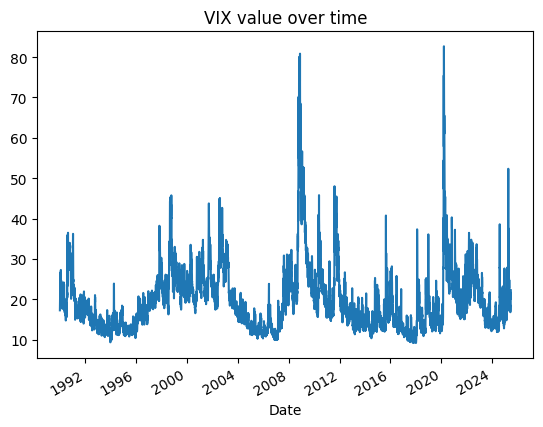

In [89]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Close'].plot.line(title = "VIX value over time")

In [90]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [91]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [92]:
gold.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-19 00:00:00-04:00,3387.100098,3405.199951,3363.600098,3384.399902,114667,0.0,0.0


In [93]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.000945,0.987934,1.017316,0.993668,1.182227,1.659795
2025-06-19 00:00:00-04:00,0.998407,0.996467,1.019121,1.000887,1.161308,1.657070


In [94]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [95]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [96]:
crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-04:00,75.610001,76.070000,72.940002,75.139999,154264,0.0,0.0
2025-06-19 00:00:00-04:00,74.599998,77.580002,74.470001,77.349998,3055,0.0,0.0


In [97]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.004009,1.029597,1.150865,1.271620,1.058310,1.040864
2025-06-19 00:00:00-04:00,1.029412,1.077748,1.190366,1.332013,1.069552,1.047961


In [98]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [99]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-04:00,77.190002,77.430000,74.440002,76.699997,88748,0.0,0.0
2025-06-19 00:00:00-04:00,76.120003,79.019997,75.680000,78.699997,30368,0.0,0.0


In [100]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.003270,1.033275,1.144093,1.234111,1.027324,0.988529
2025-06-19 00:00:00-04:00,1.026076,1.074696,1.176910,1.287631,1.037301,0.999238


In [101]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


In [102]:
# Bitcoin prices: BTC_USD
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00+00:00,104602.070312,105581.851562,103602.265625,104883.328125,47318089133,0.0,0.0
2025-06-19 00:00:00+00:00,104908.757812,105217.031250,104180.101562,104189.945312,40880439296,0.0,0.0


In [103]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-18 00:00:00+00:00,1.002698,0.993665,0.965007,0.993155,1.246131,1.610103
2025-06-19 00:00:00+00:00,0.993389,0.975591,0.983582,0.975643,1.239718,1.603902


In [104]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [106]:
#!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [ ]:
# import eurostat

# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

#filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-18'}

#code = 'irt_euryld_d'
#eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [107]:
#eurostat_euro_yield_df.info()

In [108]:
#eurostat_euro_yield_df.head()

In [109]:
#eurostat_euro_yield_df['bonds'].value_counts()

In [110]:
#eurostat_euro_yield_df['maturity'].value_counts()

In [111]:
#eurostat_euro_yield_df['yld_curv'].value_counts()

In [112]:
#eurostat_euro_yield_df

In [113]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
#FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
#filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [114]:
#filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(20)

In [115]:
#filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(20)

In [116]:
#import re

#def extract_numbers(input_string):
#    y_match = re.search(r'Y(\d+)', input_string)
#    m_match = re.search(r'M(\d+)', input_string)

#    y_number = int(y_match.group(1)) if y_match else 0
#    m_number = int(m_match.group(1)) if m_match else 0

#    return y_number*12 + m_number

# Examples
#examples = ["Y10_M2", "M3", "Y1"]
#for example in examples:
#    res = extract_numbers(example)
#    print(f"{example} ==> {res}")

In [ ]:
# define new field: "maturity in months"
#filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

In [117]:
#filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

In [ ]:
#filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

In [118]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
#filtered_eurostat_euro_yield_df \
#  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
#  .plot.line(x='maturity_in_years',
#            y='2025-05-29_value',
#            title='AAA rated bonds spot yield curve')

#### Merge All Data into a Dataframe

In [119]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-19 00:00:00+02:00,0.989135,0.97322,0.961518,0.987658,1.052607,1.381949


In [120]:
dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)

In [121]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [122]:
m2.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,6,...,0,0,0,0,0.989135,0.97322,0.961518,0.987658,1.052607,1.381949


In [123]:
# check the same number of records, but columns increased
m2.shape

(230374, 151)

In [124]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,0.999691,1.000652,0.995836,1.066696,0.992512,1.271225


In [125]:
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)

In [126]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [127]:
m3.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,6,...,0.961518,0.987658,1.052607,1.381949,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
m3.shape

(230374, 157)

In [129]:
dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)

In [130]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [131]:
m4.shape

(230374, 163)

In [132]:
m4.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)

In [134]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [135]:
m5.shape

(230374, 169)

In [136]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

,Quarter
0,1986-01-01
1,1986-01-01
2,1986-01-01
3,1986-01-01
4,1986-01-01
...,...
5700,2025-04-01
5701,2025-04-01
5702,2025-04-01
5703,2025-04-01


In [137]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [138]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [139]:
m6.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,6,...,1.126675,0.998477,0.991571,0.975755,1.010795,1.064995,1.12307,2025-04-01,0.023029,0.005716
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716


In [140]:
m6.shape

(230374, 172)

In [141]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

,Month
0,1986-03-01
1,1986-03-01
2,1986-03-01
3,1986-03-01
4,1986-03-01
...,...
5700,2025-06-01
5701,2025-06-01
5702,2025-06-01
5703,2025-06-01


In [142]:
cpilfesl_to_merge.tail(1)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-05-01,0.027671,0.001299


In [143]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [144]:
# PROBLEM! Last month is not defined
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,NaN,NaN


In [145]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()

In [146]:
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299


In [147]:
fedfunds.tail(1)

,FEDFUNDS
DATE,
2025-05-01,4.33


In [148]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [149]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,NaN


In [150]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()

In [151]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5704,3607.0,3643.0,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33


In [152]:
dgs1.tail(1)

,DGS1
DATE,
2025-06-17,4.1


In [153]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [154]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.010795,1.064995,1.12307,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN


In [155]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [156]:
# fix last day later
m10.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.064995,1.12307,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN


In [157]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [158]:
m11.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.12307,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN


In [159]:
vix_to_merge

,Close
Date,
1990-01-02 00:00:00-06:00,17.240000
1990-01-03 00:00:00-06:00,18.190001
1990-01-04 00:00:00-06:00,19.219999
1990-01-05 00:00:00-06:00,20.110001
1990-01-08 00:00:00-06:00,20.260000
...,...
2025-06-13 00:00:00-05:00,20.820000
2025-06-16 00:00:00-05:00,19.110001
2025-06-17 00:00:00-05:00,21.600000


In [160]:
vix_to_merge.index = vix_to_merge.index.tz_localize(None)

In [161]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [162]:
m12.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Close_y
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,20.139999
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,22.240000


In [163]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.000945,0.987934,1.017316,0.993668,1.182227,1.659795
2025-06-19 00:00:00-04:00,0.998407,0.996467,1.019121,1.000887,1.161308,1.657070


In [164]:
gold_to_merge.index = gold_to_merge.index.tz_localize(None)

In [165]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [166]:
m13.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,DGS1,DGS5,DGS10,Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,20.139999,1.000945,0.987934,1.017316,0.993668,1.182227,1.659795
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,22.240000,0.998407,0.996467,1.019121,1.000887,1.161308,1.657070


In [167]:
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)

In [168]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [169]:
m14.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.017316,0.993668,1.182227,1.659795,1.004009,1.029597,1.150865,1.271620,1.058310,1.040864
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.019121,1.000887,1.161308,1.657070,1.029412,1.077748,1.190366,1.332013,1.069552,1.047961


In [170]:
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)

In [171]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [172]:
m15.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.150865,1.271620,1.058310,1.040864,1.003270,1.033275,1.144093,1.234111,1.027324,0.988529
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.190366,1.332013,1.069552,1.047961,1.026076,1.074696,1.176910,1.287631,1.037301,0.999238


In [173]:
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [174]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [175]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.144093,1.234111,1.027324,0.988529,1.002698,0.993665,0.965007,0.993155,1.246131,1.610103
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.176910,1.287631,1.037301,0.999238,0.993389,0.975591,0.983582,0.975643,1.239718,1.603902


In [176]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [177]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5703,3622.0,3639.100098,3587.199951,3601.500000,743311.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.144093,1.234111,1.027324,0.988529,1.002698,0.993665,0.965007,0.993155,1.246131,1.610103
5704,3607.0,3643.000000,3591.100098,3621.100098,1580686.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.176910,1.287631,1.037301,0.999238,0.993389,0.975591,0.983582,0.975643,1.239718,1.603902


In [178]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230374 entries, 0 to 5704
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.3+ MB


In [179]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2025_06_19


In [180]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')

In [182]:
m16.columns

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

Step 2:  IMPORTANT Please use this file to solve the Home Assignment (all next steps)

Download precomputed data using this snippet:

In [201]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")


Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=73da2fb5-b5e4-4511-8072-bb7c54e33dab
To: /content/data.parquet
100%|██████████| 130M/130M [00:02<00:00, 63.9MB/s]


Step 3: **RSI Strategy Setup**:

RSI is already available in the dataset as a field.

The threshold for **oversold** is defined as RSI < 25.

In [202]:
df['rsi'].info()

<class 'pandas.core.series.Series'>
Index: 229932 entries, 0 to 5690
Series name: rsi
Non-Null Count   Dtype  
--------------   -----  
229470 non-null  float64
dtypes: float64(1)
memory usage: 3.5 MB


Step 4: Filter the dataset by RSI and date:

In [203]:
rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]

Step 5:
Calculate Net Profit Over 25 Years:

* Total number of trades: 1568

* For each trade, you invest $1000

* Use the 30-day forward return (growth_future_30d) to compute net earnings:

In [205]:
selected_df['growth_future_30d']

,growth_future_30d
3668,0.985394
3669,0.972222
3680,0.964641
3681,1.005637
3682,0.981941
...,...
4405,1.007871
4406,0.981580
4407,1.118479
4408,1.142111


In [206]:
# net income with $1000 investment
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()

In [207]:
float(net_income)

24295.523125248386

Final Answer:

What is the net income in $K (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

In [208]:
net_income_k = net_income / 1000
print(f"Net income in $K: {net_income_k:.2f}")

Net income in $K: 24.30


### Question 5

Ideas for identifying IPOs with positive future returns and building a more effective trading strategy for increased profitability:

* Predictive modelling: build a classification model to predict future returns using good feature engineering technique
* Use news sentiment, web traffic, or social media hype metrics (e.g., Reddit mentions) to assess demand.
* Use fundamentals if available: revenue growth, profitability (positive EBITDA), low debt-to-equity.
* Combine low RSI (e.g., < 30) with volume surges or MACD crossovers for timing entries on pullbacks.
* Use macro indicators (e.g., VIX, interest rate trends) to time entries.